In [75]:
# Lectura del conjunto de datos utilizando Pandas
import pandas as pd
from datetime import datetime
dolar = pd.read_csv('dolarMEP.csv')
df = pd.read_csv('lista_prestamos.csv')
df

,Fecha,Destino,Edad,Ingresos,Zona geografica,Perfil,Plazo,Cuota,class
0,22/03/2024,Refaccion y construccion de vivienda,45,2000000,Buenos Aires,A,6,1,Al dia
1,18/03/2024,Decoracion,40,5000000,La Pampa,AA,6,1,Al dia
2,21/02/2024,Refaccion y construccion de vivienda,52,935000,Rio Negro,AA,18,1,Al dia
3,19/02/2024,Viaje,70,450000,Corrientes,AA,18,1,Al dia
4,06/02/2024,Refaccion y construccion de vivienda,57,326000,Buenos Aires,C,6,1,Al dia
...,...,...,...,...,...,...,...,...,...
401,10/01/2018,Decoracion,45,21600,Buenos Aires,F,48,48,+180 dias
402,09/01/2018,Otros destinos,36,14000,Santa Fe,D,48,48,+180 dias
403,04/01/2018,Refaccion y construccion de vivienda,50,30000,Buenos Aires,E,48,48,+180 dias
404,04/01/2018,Refaccion y construccion de vivienda,35,32355,Ciudad de Buenos Aires,D,48,48,+180 dias


In [76]:
# Realizamos una copia del original para no trabajar sobre esta
df_orig= df.copy()
df.head()

,Fecha,Destino,Edad,Ingresos,Zona geografica,Perfil,Plazo,Cuota,class
0,22/03/2024,Refaccion y construccion de vivienda,45,2000000,Buenos Aires,A,6,1,Al dia
1,18/03/2024,Decoracion,40,5000000,La Pampa,AA,6,1,Al dia
2,21/02/2024,Refaccion y construccion de vivienda,52,935000,Rio Negro,AA,18,1,Al dia
3,19/02/2024,Viaje,70,450000,Corrientes,AA,18,1,Al dia
4,06/02/2024,Refaccion y construccion de vivienda,57,326000,Buenos Aires,C,6,1,Al dia


In [77]:
# vemos que tipo de datos tiene el data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Fecha            406 non-null    object
 1   Destino          406 non-null    object
 2   Edad             406 non-null    int64 
 3   Ingresos         406 non-null    int64 
 4   Zona geografica  406 non-null    object
 5   Perfil           406 non-null    object
 6   Plazo            406 non-null    int64 
 7   Cuota            406 non-null    int64 
 8   class            406 non-null    object
dtypes: int64(4), object(5)
memory usage: 28.7+ KB


In [78]:
# Al analizar la base de datos, tendremos que hacer varias modificaciones para representarlo correctamente 
# para ingresos lo pasaremos a dolares utilizando una base de dato donde tenemos según meses el valor máximo de valor mep
# con respecto a la cuota lo dividiremos por el plazo para tener un porcentaje de avance de los pagos 
# con respecto a clases dividiremos en los que son "Al dia" -> "bueno" y todos los demas como "malo"
# cuando ingresemos una nueva entrada lo pasaremos por esta función 

dolar_prueba = dolar.copy()
df_prueba= df.copy()



def editor_fichero(fichero,fichero_dolar):

    def convertir_etiqueta(fichero): #empezamos por class
        fichero.loc[fichero['class'] == 'Al dia', 'class'] = 'Bueno'
        fichero.loc[fichero['class'] != 'Bueno', 'class'] = 'malo'
        return fichero
    

    def convertir_cuota_en_porcentaje(fichero): #modificamos las cuotas por un porcentaje de avance del cuota/plazo
        fichero['porcentaje_Avance'] = fichero['Cuota']/fichero['Plazo']
        del fichero['Cuota']
        return fichero
    
    def pasar_ingresos_a_dolares(fichero, fichero_dolar):  #pasar a dolares los ingresos - sacamos el mayor dolar de cada mes y ese será el valor a convertir
       
        #transformamos las columnas de fecha a variable datetime
        fichero['Fecha'] = pd.to_datetime(fichero['Fecha'], dayfirst=True, errors='ignore')
        fichero_dolar['Fecha'] =pd.to_datetime(fichero_dolar['Fecha'], dayfirst=True, errors='ignore')

        #creamos una nueva columna del dolar para esa fecha en particular, luego los ingresos se dividiran por este dolar
        fichero['dolar']=""
        fichero['ingresos en dolares']=""

        for x in range(0,(len(fichero.index)),1):
            cond=False
            cont=0
            dia=pd.to_timedelta('1 days')


            while cond==False:
                cont=cont+1
                for y in range(0,(len(fichero_dolar.index)),1):
                    if (fichero.loc[(x,'Fecha')]+dia*cont)==fichero_dolar.loc[(y,'Fecha')]:
                        fichero.loc[(x,'dolar')] = fichero_dolar.loc[(y,'dolar')]
                        cond=True
                        break  

        fichero['ingresos en dolares'] = (fichero['Ingresos'] / fichero['dolar']).astype('float64')
        
        del fichero['Ingresos']
        del fichero['Fecha']
        del fichero['dolar']
        
        return fichero
    
    return pasar_ingresos_a_dolares(convertir_cuota_en_porcentaje(convertir_etiqueta(fichero)),fichero_dolar)


editor_fichero(df_prueba, dolar_prueba)
df_prueba




,Destino,Edad,Zona geografica,Perfil,Plazo,class,porcentaje_Avance,ingresos en dolares
0,Refaccion y construccion de vivienda,45,Buenos Aires,A,6,Bueno,0.166667,1974.450609
1,Decoracion,40,La Pampa,AA,6,Bueno,0.166667,4843.271727
2,Refaccion y construccion de vivienda,52,Rio Negro,AA,18,Bueno,0.055556,886.440774
3,Viaje,70,Corrientes,AA,18,Bueno,0.055556,416.547102
4,Refaccion y construccion de vivienda,57,Buenos Aires,C,6,Bueno,0.166667,271.800302
...,...,...,...,...,...,...,...,...
401,Decoracion,45,Buenos Aires,F,48,malo,1.000000,1066.140178
402,Otros destinos,36,Santa Fe,D,48,malo,1.000000,691.016782
403,Refaccion y construccion de vivienda,50,Buenos Aires,E,48,malo,1.000000,1480.750247
404,Refaccion y construccion de vivienda,35,Ciudad de Buenos Aires,D,48,malo,1.000000,1596.989141


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Destino              406 non-null    object 
 1   Edad                 406 non-null    int64  
 2   Zona geografica      406 non-null    object 
 3   Perfil               406 non-null    object 
 4   Plazo                406 non-null    int64  
 5   class                406 non-null    object 
 6   porcentaje_Avance    406 non-null    float64
 7   ingresos en dolares  406 non-null    float64
dtypes: float64(2), int64(2), object(4)
memory usage: 25.5+ KB


array([[<Axes: title={'center': 'Edad'}>,
        <Axes: title={'center': 'Plazo'}>],
       [<Axes: title={'center': 'porcentaje_Avance'}>,
        <Axes: title={'center': 'ingresos en dolares'}>]], dtype=object)

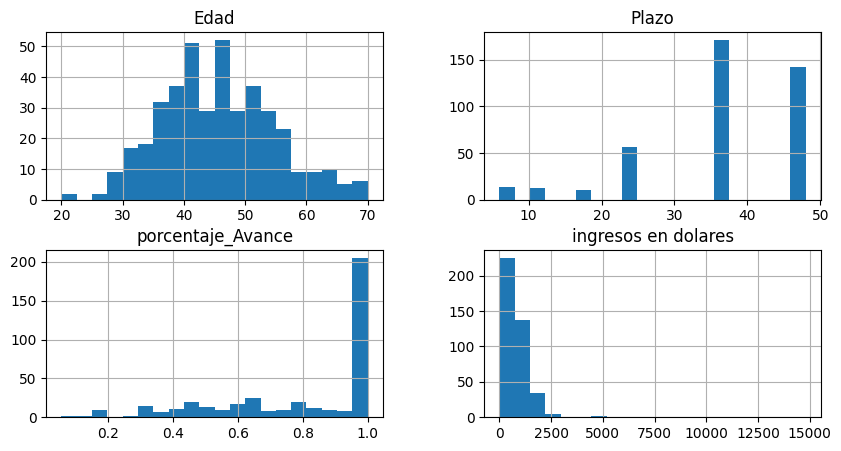

In [79]:
# Representar gráficamente la distribución de los atributos
df_prueba.info()
df_prueba.hist(bins=20, figsize=(10,5))

Longitud del Training Set: 324
Longitud del Validation Set: 41
Longitud del Test Set: 41


<Axes: >

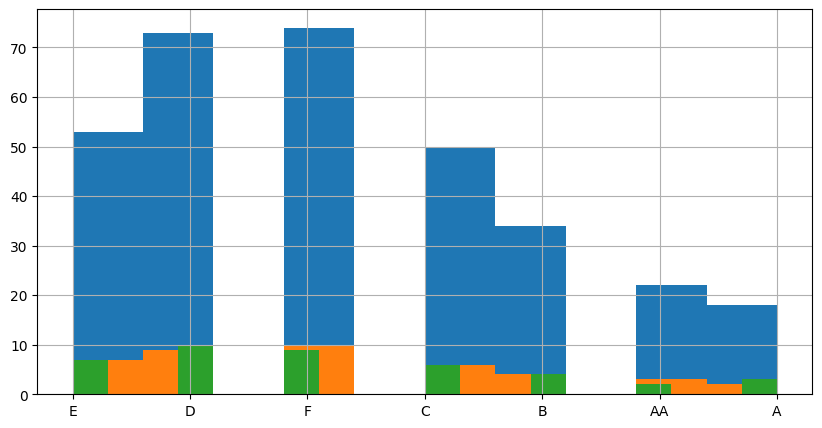

In [80]:
# del conjunto que ya procesamos haremos una división de datos de forma aleatoria - datos de entrenamientos 80% - datos de test 10% - 10% datos de validación 
# Separamos el conjunto de datos 80% train set, 20% test set - como afluenta tiene un rango de score vamos a usar para que la división aleatoria
# se realice de forma proporcional del Perfil.

import sklearn
from sklearn.model_selection import train_test_split
df_prueba
#la función principal de train test split divide en dos conjuntos por esto vamos a realizar una función que me divida en train y set y que tambien el set divida en 2 para tener set y validación
# Construcción de una función que realice el particionado completo se debe poner el fichero, proporcion para train,test,val, y la variable para el stratify
def particionador(df, rstate=42, shuffle=True, st=None):
    strat=df[st]
    train_set, test_set = train_test_split(df, test_size=0.2 , random_state=rstate, shuffle=shuffle , stratify=strat)
    
    df=test_set
    strat=df[st]
    test_set, val_set = train_test_split(df, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    
    return (train_set, val_set, test_set)
    
train_set, val_set, test_set = particionador(df=df_prueba ,rstate=42, shuffle=True, st='Perfil')   

print("Longitud del Training Set:", len(train_set))
print("Longitud del Validation Set:", len(val_set))
print("Longitud del Test Set:", len(test_set))

%matplotlib inline
import matplotlib.pyplot as plt
train_set["Perfil"].hist()
test_set["Perfil"].hist()
val_set["Perfil"].hist(bins=20, figsize=(10,5))

In [81]:
#transformaremos a travez de Sklearn ->LabelEncoder de valores categoricos a numéricos (Destino-Zona Geografica-Perfil-class)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder

# Conjunto de datos general
X_df = df_prueba.drop("class", axis=1)
y_df = df_prueba["class"].copy()
# Conjunto de datos de entrenamiento
X_train = train_set.drop("class", axis=1)
y_train= train_set["class"].copy()
# Conjunto de datos de validación
X_val = val_set.drop("class", axis=1)
y_val = val_set["class"].copy()
# Conjunto de datos de pruebas
X_test = test_set.drop("class", axis=1)
y_test= test_set["class"].copy()




# Transformamos los valores del atributo class de categoricos a numéricos
labelencoder = LabelEncoder()
y_df= labelencoder.fit_transform(y_df)
y_train = labelencoder.fit_transform(y_train)
y_val = labelencoder.fit_transform(y_val)
y_test= labelencoder.fit_transform(y_test)

# Transormador para codificar únicamente las columnas categoricas y devolver un df
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self._oh = OneHotEncoder()
        self._columns = None
        
    def fit(self, X, y=None):
        X_cat = X.select_dtypes(include=['object'])
        self._columns = pd.get_dummies(X_cat).columns
        self._oh.fit(X_cat)
        return self
        
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_cat = X_copy.select_dtypes(include=['object'])
        X_num = X_copy.select_dtypes(exclude=['object'])
        X_cat_oh = self._oh.transform(X_cat)
        X_cat_oh = pd.DataFrame(X_cat_oh.toarray(), 
                                columns=self._columns, 
                                index=X_copy.index)
        X_copy.drop(list(X_cat), axis=1, inplace=True)
        return X_copy.join(X_cat_oh)
    
# Construcción de un pipeline para los atributos numéricos
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('rbst_scaler', RobustScaler()),
    ])    

# Transofrmador que prepara todo el conjunto de datos llamando pipelines y transformadores personalizados
class DataFramePreparer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self._full_pipeline = None
        self._columns = None
        
    def fit(self, X, y=None):
        num_attribs = list(X.select_dtypes(exclude=['object']))
        cat_attribs = list(X.select_dtypes(include=['object']))
        self._full_pipeline = ColumnTransformer([
                ("num", num_pipeline, num_attribs),
                ("cat", CustomOneHotEncoder(), cat_attribs),
        ])
        self._full_pipeline.fit(X)
        self._columns = pd.get_dummies(X).columns
        return self
        
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_prep = self._full_pipeline.transform(X_copy)
        return pd.DataFrame(X_prep, 
                            columns=self._columns, 
                            index=X_copy.index)

# Instanciamos nuestro transformador personalizado
data_preparer = DataFramePreparer()

# Hacemos el fit con el conjunto de datos general para que adquiera todos los valores posibles
data_preparer.fit(X_df)

# Transformamos el subconjunto de datos de entrenamiento
X_train_prep = data_preparer.transform(X_train)

X_train.head(5)
X_train_prep.head(5)

# Transformamos el subconjunto de datos de validacion
X_val_prep = data_preparer.transform(X_val)


In [82]:
#entrenamiento, luego de preparar los datos empezaremos a reaizar los entrenamientos 

# Entrenamos un algoritmo basado en regresión logística
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver="newton-cg", max_iter=1000)
clf.fit(X_train_prep, y_train)


LogisticRegression(max_iter=1000, solver='newton-cg')

F1 score: 0.8727272727272727
F1 score: 0.8627450980392157


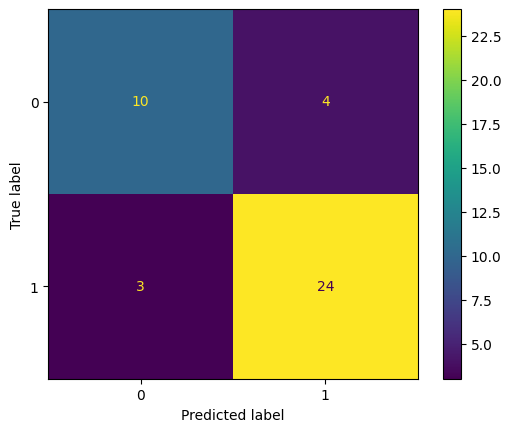

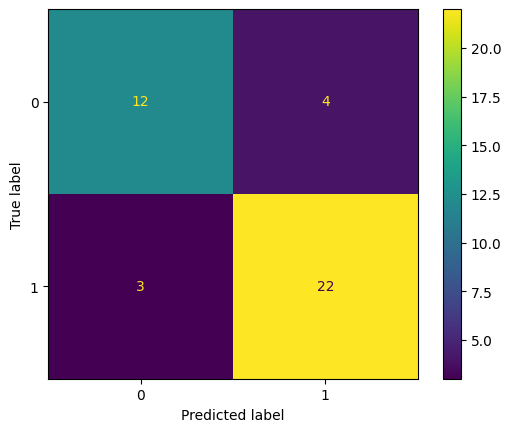

In [83]:
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
#Realizamos una predicción con el modelo generado anteriormente tras el entrenamiento del algoritmo de Regresión Logística. Utilizamos el subconjunto de validación.
y_pred = clf.predict(X_val_prep)
print("F1 score:", f1_score(y_val, y_pred))
confusion_matrix(y_val, y_pred)
ConfusionMatrixDisplay.from_estimator(clf, X_val_prep, y_val, values_format='d')

# Transformamos el subconjunto de datos de validacion
X_test_prep = data_preparer.transform(X_test)
y_pred = clf.predict(X_test_prep)
ConfusionMatrixDisplay.from_estimator(clf, X_test_prep, y_test, values_format='d')
print("F1 score:", f1_score(y_test, y_pred))

In [84]:

print(X_train_prep)
print(X_train)
print(X_train)
print(y_test)
print(y_pred)

         Edad  Plazo  porcentaje_Avance  ingresos en dolares  \
398 -0.705882    1.0           0.100000             0.358746   
143  0.627451    0.0          -0.700000            -0.094310   
356 -0.470588    0.0           0.100000             0.316633   
400 -0.313725    1.0           0.100000             0.526095   
290  1.882353    1.0           0.100000            -0.411563   
..        ...    ...                ...                  ...   
382  0.235294    1.0           0.100000             0.899454   
276  0.078431    1.0           0.100000             0.000729   
243  0.078431    0.0           0.100000            -0.345670   
206 -0.156863    0.0          -0.233333            -0.378381   
112  0.784314    0.0          -0.833333            -0.469939   

     Destino_Cambio de vehiculo  Destino_Celebracion  \
398                         0.0                  0.0   
143                         0.0                  0.0   
356                         0.0                  0.0   
400    